<a href="https://colab.research.google.com/github/himanshudce/APM_BPI_2020/blob/main/notebooks/model_building_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
import numpy as np
import sklearn
from tqdm.auto import tqdm

In [3]:
import pickle
import numpy

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold,train_test_split, RandomizedSearchCV
np.random.seed(42)

# Event Log & Data Loading

In [5]:
# function to load the data from pickle
def load_data(load_path):
    with open(load_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [6]:
data_test = load_data("../data/training_data/boolean_encode_test_trace_len_6.pickle")
data_train = load_data("../data/training_data/boolean_encode_train_trace_len_6.pickle")

# Model Building

## Scaling
If needed, would take place here. Not required for binary values.

In [43]:
X_train = np.array(data_train['X'])
X_test = np.array(data_test['X'])
y_train = np.array(data_train['y'])
y_test = np.array(data_test['y'])

In [44]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2825
2825
460
460


In [27]:
# scaler_x = MinMaxScaler()
# data_scaled = scaler_x.fit_transform(data_dict['X'])

# scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
# target_scaled = scaler_y.fit_transform(data_dict['y'].reshape(-1, 1))

## Setting up Model Evaluation DataFrame
All the results will be saved to the `results_df` dataframe for comparison.

In [45]:
results_df = pd.DataFrame(index=['Decision Tree (Default)'],
                          columns=['F-score', 'Precision','Recall', 'Accuracy'])

## Decision Tree Classifier

In [49]:
# Create Decision Tree classifier object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifier
dt_fit = dt.fit(X_train,y_train)

#Predict the response for test dataset
dt_predict = dt_fit.predict(X_test)

results_df.loc['Decision Tree (Default)',:] = [f1_score(y_test,dt_predict, average='macro'), precision_score(y_test,dt_predict), recall_score(y_test,dt_predict),accuracy_score(y_test,dt_predict)]

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.45433,0.0,0.0,0.832609


[Text(0.5, 0.9, 'x[5] <= 0.5\ngini = 0.28\nsamples = 2825\nvalue = [2349, 476]'),
 Text(0.25, 0.7, 'x[7] <= 0.5\ngini = 0.079\nsamples = 703\nvalue = [674, 29]'),
 Text(0.125, 0.5, 'gini = 0.0\nsamples = 473\nvalue = [473, 0]'),
 Text(0.375, 0.5, 'gini = 0.22\nsamples = 230\nvalue = [201, 29]'),
 Text(0.75, 0.7, 'x[8] <= 0.5\ngini = 0.333\nsamples = 2122\nvalue = [1675, 447]'),
 Text(0.625, 0.5, 'x[12] <= 0.5\ngini = 0.34\nsamples = 2058\nvalue = [1611, 447]'),
 Text(0.5, 0.3, 'x[6] <= 0.5\ngini = 0.342\nsamples = 1957\nvalue = [1528, 429]'),
 Text(0.375, 0.1, 'gini = 0.342\nsamples = 1288\nvalue = [1006, 282]'),
 Text(0.625, 0.1, 'gini = 0.343\nsamples = 669\nvalue = [522, 147]'),
 Text(0.75, 0.3, 'gini = 0.293\nsamples = 101\nvalue = [83, 18]'),
 Text(0.875, 0.5, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]')]

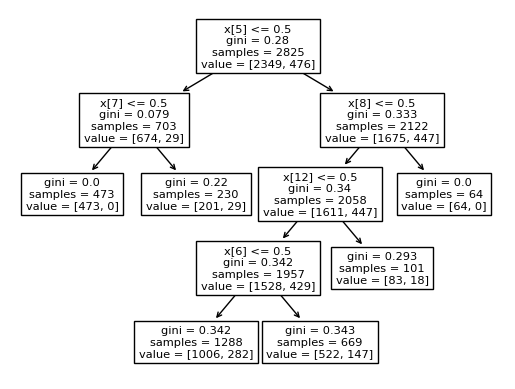

In [71]:
tree.plot_tree(dt_fit)

# Logistic Regression


In [31]:
# Training the Logistic Regression model on the Training set
lr = LogisticRegression(random_state=42)
lr_fit = lr.fit(X_train, y_train)
# Predicting the Test set results
lr_predict = lr_fit.predict(X_test)

results_df.loc['Logistic Regression (Default)',:] = [f1_score(y_test,lr_predict, average='macro'), precision_score(y_test,lr_predict), recall_score(y_test,lr_predict),accuracy_score(y_test,lr_predict)]

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.45433,0.0,0.0,0.832609
Logistic Regression (Default),0.45433,0.0,0.0,0.832609


In [59]:
solvers = ['lbfgs','newton-cg','liblinear','sag','saga']
penalty = ['l1', 'l2', 'elasticnet', 'None']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iteration= [20, 50, 100, 200, 500, 1000, 2000, 5000]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iteration)

lr_grid = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
lr_grid_fit = lr_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(lr_grid.best_estimator_, X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression (Hyper Parameter Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.45433,0.0,0.0,0.832609
Logistic Regression (Hyper Parameter Tuning),0.454001,0.415752,0.5,0.831504


# Random Forest Classifier

In [60]:
# rf = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=4)
# rf_fit = rf.fit(X_train, y_train)
# # Predicting the Test set results
# rf_predict = rf_fit.predict(X_test)
#
# results_df.loc['Random Forest (Default)',:] = [f1_score(y_test,rf_predict, average='macro'), precision_score(y_test,rf_predict), recall_score(y_test,rf_predict),accuracy_score(y_test,rf_predict)]
#
# results_df.sort_values(by='F-score', ascending=False)
#

rf = RandomForestClassifier()
n_estimators = [1,5,10,40,100,200,500,1000,2000,5000]
max_features = ['sqrt', 'log2']
max_depth = [1,3,5,7,9,11,13,15,20]
criterion= ['gini', 'entropy']

grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)
rf_random_fit = rf_random.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(rf_random.best_estimator_ , X_train, y_train, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Random Forest (Randomized Parameters)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.45433,0.0,0.0,0.832609
Logistic Regression (Hyper Parameter Tuning),0.454001,0.415752,0.5,0.831504
Random Forest (Randomized Parameters),0.454001,0.415752,0.5,0.831504


# MLP (Neural Network) Classifier

In [63]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[1*i,1*i] for i in range(1,5)]
sizes = sizes + [[1*i,1*i, 1*i] for i in range(1,5)]

decays = [3,4,5,6,7,8]

nnet = MLPClassifier(alpha=0,
                     activation='logistic',
                           max_iter=500,
                           solver='lbfgs',
                           random_state=42)

nnet_grid = GridSearchCV(estimator=nnet,
                   scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays,},
                   return_train_score=True,
                   refit='f1_macro')

nnet_grid_fit = nnet_grid.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(nnet_grid.best_estimator_, X_train, y_train, scoring = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP (Hyper Parameter Tuning)',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score', ascending=False)

/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/CODE_Repositories/APM_BPI_2020/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,F-score,Precision,Recall,Accuracy
Decision Tree (Default),0.45433,0.0,0.0,0.832609
MLP (Default),0.45433,0.0,0.0,0.832609
Logistic Regression (Hyper Parameter Tuning),0.454001,0.415752,0.5,0.831504
Random Forest (Randomized Parameters),0.454001,0.415752,0.5,0.831504
MLP (Hyper Parameter Tuning),0.454001,0.415752,0.5,0.831504


In [64]:
print(nnet_grid.best_params_)
print(nnet_grid.best_estimator_.n_iter_)
print(nnet_grid.best_estimator_.n_layers_)

{'alpha': 3, 'hidden_layer_sizes': 2}
38
3
